In [13]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

In [14]:
image_dir = Path('./20-50/test')
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
ages = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Age').astype(np.int32)

test = pd.concat([filepaths, ages], axis=1)
test.head()

,Filepath,Age
0,20-50/test/20/28492.jpg,20
1,20-50/test/20/28521.jpg,20
2,20-50/test/20/28681.jpg,20
3,20-50/test/20/28801.jpg,20
4,20-50/test/20/28815.jpg,20


In [15]:
image_dir = Path('./20-50/train')
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
ages = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Age').astype(np.int32)

images = pd.concat([filepaths, ages], axis=1)
images.head()

,Filepath,Age
0,20-50/train/20/144864.jpg,20
1,20-50/train/20/122542.jpg,20
2,20-50/train/20/122550.jpg,20
3,20-50/train/20/122573.jpg,20
4,20-50/train/20/122642.jpg,20


Age: 20
(128, 128, 3)


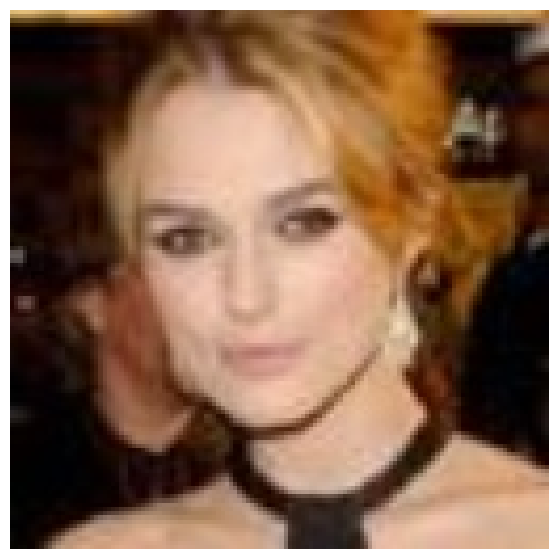

In [16]:
def visualize(image):
    plt.figure(figsize=(7, 7))
    plt.axis('off')
    plt.imshow(image)

#choose an image id to see its age
image_id = 32
image_example_path = images.iloc[image_id].Filepath
age = images.iloc[image_id].Age

print(f'Age: {age}')
image = cv2.imread(image_example_path)
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, '20'),
  Text(1, 0, '21'),
  Text(2, 0, '22'),
  Text(3, 0, '23'),
  Text(4, 0, '24'),
  Text(5, 0, '25'),
  Text(6, 0, '26'),
  Text(7, 0, '27'),
  Text(8, 0, '28'),
  Text(9, 0, '29'),
  Text(10, 0, '30')])

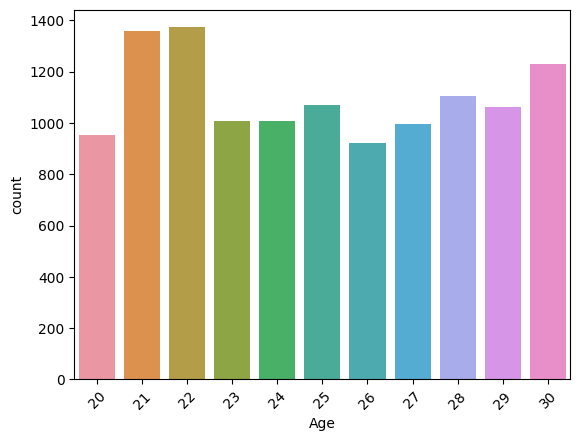

In [17]:
sns.countplot(x='Age', data=images)
plt.xticks(rotation = 45)

We will go for a 31-class classification approach:
class 0: 20 years
...
class 31: 50 years

In [18]:
images.Age = images.Age - 20

In [19]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(images, test_size=0.2, random_state=2)

In [20]:
class ImageAgeDataset():
    def __init__(self, images):
        self.age = images.Age.values
        self.paths = images.Filepath.values
        
    def __len__(self):
        return len(self.age)
    
    def __getitem__(self, item):
        out = dict()
        path = self.paths[item]
        image = cv2.imread(path)
        image = cv2.resize(image, (128, 128))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image, dtype=float)
        out['x'] = torch.tensor(image, dtype = torch.float).permute(2, 0, 1)/255
        out['y'] = torch.tensor(self.age[item], dtype = torch.long)
        return out

In [21]:
train_dataset = ImageAgeDataset(train)
valid_dataset = ImageAgeDataset(valid)

In [22]:
class AlexNetwork(nn.Module):
    def __init__(self, n_classes):
        super(AlexNetwork, self).__init__()
        self.n_classes = n_classes
        self.conv_1 = nn.Conv2d(
            in_channels=3,
            out_channels=64,  # Reduced from 96
            kernel_size=11,
            stride=4,
            padding=58
        )
        self.pool_1 = nn.MaxPool2d(
            kernel_size=3,
            stride=2
        )
        self.conv_2 = nn.Conv2d(
            in_channels=64,  # Input channels reduced from 96
            out_channels=192,  # Reduced from 256
            kernel_size=5,
            stride=1,
            padding=2
        )
        self.pool_2 = nn.MaxPool2d(
            kernel_size=3,
            stride=2
        )
        self.conv_3 = nn.Conv2d(
            in_channels=192,  # Input channels reduced from 256
            out_channels=384,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.conv_4 = nn.Conv2d(
            in_channels=384,
            out_channels=256,  # Reduced from 384
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.conv_5 = nn.Conv2d(
            in_channels=256,
            out_channels=256,  # Reduced from 384
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.pool_3 = nn.MaxPool2d(
            kernel_size=3,
            stride=2
        )
        self.nn = nn.Sequential(nn.Linear(in_features=9216, out_features=2048),
                                nn.ReLU(),
                                nn.Linear(in_features=2048, out_features=1024),
                                nn.ReLU(),
                                nn.Linear(in_features=1024, out_features=self.n_classes)
                               )
    
    def forward(self, x):
        x = self.conv_1(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.pool_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.conv_5(x)
        x = self.pool_3(x)
        x = x.view(-1, 9216)
        x = self.nn(x)
        
        return x


In [23]:
DEVICE = torch.device('cude') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 50
MAX_WAIT = 3
EPOCHS = 10
LR = 10

train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
#     num_workers = 8
)

valid_dataloader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
#     num_workers=8
)

model = AlexNetwork(11)
model.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

from tqdm.notebook import tqdm
import numpy as np

def train_step(model, optimizer, dataloader):
    model.train()
    total_loss = 0
    for data in tqdm(dataloader):
        x = data['x'].to(DEVICE)
        y = data['y'].to(DEVICE)
        y_hat = model(x).to(DEVICE) #to apply model(x), x and model must be in the same place (device)
        loss = loss_fn(y_hat, y) #enough for y_hat and y to be in the same device
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        
    return total_loss/len(dataloader)

def valid_step(model, dataloader):
    model.eval()
    total_loss = 0
    for data in tqdm(dataloader):
        x = data['x'].to(DEVICE)
        y = data['y'].to(DEVICE)
        with torch.no_grad():
            y_hat = model(x).to(DEVICE)
            loss = loss_fn(y_hat, y)
            
        total_loss += loss.item()
    return total_loss/len(dataloader)

def main(model, optimizer, train_dataloader, valid_dataloader):
    train_losses = []
    valid_losses = []
    min_valid_loss = np.inf
    patience = 0
    
    for epoch in range(EPOCHS):
        train_loss = train_step(model, optimizer, train_dataloader)
        train_losses.append(train_loss)
        valid_loss = valid_step(model, valid_dataloader)
        valid_losses.append(valid_loss)
        
        print(f'EPOCH = {epoch}')
        print(f'train_loss = {train_loss}')
        print(f'valid_loss = {valid_loss}')
        
        if valid_loss > min_valid_loss:
            patience += 1
        else:
            min_valid_loss = valid_loss
            patience = 0
            
        if patience > MAX_WAIT:
            print(f'EARLY STOPPING AT EPOCH = {epoch}')
            break
            
    return train_losses, valid_losses

In [24]:
train_losses, valid_losses = main(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader
)

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

EPOCH = 0
train_loss = 1.9797368486797363e+25
valid_loss = 1.1061417763210761e+24


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

EPOCH = 1
train_loss = 1.7599212471179065e+23
valid_loss = 19141.172771843114


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

EPOCH = 2
train_loss = 9164.134813446359
valid_loss = 2706.132902184311


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

EPOCH = 3
train_loss = 2205.3408388747384
valid_loss = 1660.9887172154017


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

EPOCH = 4
train_loss = 2250.7718254168008
valid_loss = 1840.2346864038584


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

EPOCH = 5
train_loss = 2092.2275566808958
valid_loss = 889.956204161352


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

EPOCH = 6
train_loss = 2045.7122511716234
valid_loss = 3460.5991858657526


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

EPOCH = 7
train_loss = 1925.7143759186736
valid_loss = 1213.7456851881377


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

EPOCH = 8
train_loss = 2041.1879461229462
valid_loss = 2334.0922776825573


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

EPOCH = 9
train_loss = 1880.4962510571038
valid_loss = 1340.5127513651946
EARLY STOPPING AT EPOCH = 9


In [25]:
test_dataset = ImageAgeDataset(test)

In [26]:
len(test_dataset)

1100

In [27]:
import torch.nn.functional as F

# Create an empty list to store predicted ages
predicted_ages = []

# Iterate over each sample in the test dataset
for id in range(len(test_dataset)):
    # Perform prediction with the model
    y_hat_id = F.softmax(model(test_dataset[id]['x'].to(DEVICE)), dim=1)
    
    # Define a function to extract the predicted age
    def pred(x):
        for i in range(len(x[0])):
            if x[0][i] == torch.max(x[0]).item():
                return i
    
    # Calculate the predicted age
    val = pred(y_hat_id) + 20
    
    # Append the predicted age to the list
    predicted_ages.append(val)

# Add the predicted ages to the test DataFrame
test['predicted_age'] = predicted_ages
test.head()

,Filepath,Age,predicted_age
0,20-50/test/20/28492.jpg,20,29
1,20-50/test/20/28521.jpg,20,29
2,20-50/test/20/28681.jpg,20,29
3,20-50/test/20/28801.jpg,20,29
4,20-50/test/20/28815.jpg,20,29
